In [81]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# setting plt to inline
%matplotlib inline

In [82]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query functions
def fetcha(q):
    return cur.execute(q).fetchall()
def fetcho(q):
    return cur.execute(q).fetchone()

In [83]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [84]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [85]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [182]:
# creating initial dataframe by joining the four tables and printing first row
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
df = pd.DataFrame(fetcha(q))
df.columns = [i[0] for i in cur.description]   

In [183]:
# dropping extraneous columns
df = df.drop(['idx', 'rotten_tomatoes_link', 'movie_info', 'critics_consensus', 'directors',\
             'authors', 'actors', 'original_release_date', 'streaming_release_date',\
             'runtime', 'production_company', 'tomatometer_status', 'tomatometer_rating',\
             'tomatometer_count', 'audience_status', 'audience_rating', 'audience_count',\
             'id', 'movie'], axis=1)
df.head(1)

,movie_title,content_rating,genres,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_date,production_budget,domestic_gross,worldwide_gross
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,"Feb 12, 2010","$95,000,000","$88,768,303","$223,050,874"


In [184]:
df.columns

Index(['movie_title', 'content_rating', 'genres',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [185]:
#cleaning numerical strings and converting to floats
df['worldwide_gross'] = df['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['domestic_gross'] = df['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
df['production_budget'] = df['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [187]:
# change date string to datetime object 
df.release_date = pd.to_datetime(df.release_date)
df['year'] = df['release_date'].apply(lambda x: x.year)
df['month'] = df['release_date'].apply(lambda x: x.month)

In [188]:
df['international_gross'] = df['worldwide_gross'].sub(df['domestic_gross'])
df.head(1)

,movie_title,content_rating,genres,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_date,production_budget,domestic_gross,worldwide_gross,year,month,international_gross
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,2010-02-12,95000000.0,88768303.0,223050874.0,2010,2,134282571.0


In [189]:
#adding net profit columns
df['domestic_net'] = df['domestic_gross'].sub(df['production_budget'])
df['worldwide_net'] = df['worldwide_gross'].sub(df['production_budget'])
df['international_net'] = df['international_gross'].sub(df['production_budget'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   movie_title                       4776 non-null   object        
 1   content_rating                    4776 non-null   object        
 2   genres                            4776 non-null   object        
 3   tomatometer_top_critics_count     4776 non-null   int64         
 4   tomatometer_fresh_critics_count   4776 non-null   int64         
 5   tomatometer_rotten_critics_count  4776 non-null   int64         
 6   release_date                      4776 non-null   datetime64[ns]
 7   production_budget                 4776 non-null   float64       
 8   domestic_gross                    4776 non-null   float64       
 9   worldwide_gross                   4776 non-null   float64       
 10  year                              4776 non-null 

In [190]:
#adding return on investment columns and checking results
df['domestic_roi'] = df['domestic_net'].divide(df['production_budget'])
df['worldwide_roi'] = df['worldwide_net'].divide(df['production_budget'])
df['international_roi'] = df['international_net'].divide(df['production_budget'])
df.head(1)

,movie_title,content_rating,genres,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,release_date,production_budget,domestic_gross,worldwide_gross,year,month,international_gross,domestic_net,worldwide_net,international_net,domestic_roi,worldwide_roi,international_roi
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,2010-02-12,95000000.0,88768303.0,223050874.0,2010,2,134282571.0,-6231697.0,128050874.0,39282571.0,-0.065597,1.347904,0.413501


In [191]:
df.columns

Index(['movie_title', 'content_rating', 'genres',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'release_date', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi'],
      dtype='object')

In [192]:
df = df.rename(columns = {'movie_title':'title', 'release_date':'date',\
       'production_budget': 'budget', 'domestic_gross': 'dom_gross', 'worldwide_gross':'ww_gross',\
       'international_gross': 'intl_gross', 'domestic_net': 'dom_net', 'worldwide_net': 'ww_net',\
       'international_net': 'intl_net', 'domestic_roi': 'dom_roi', 'worldwide_roi':'ww_roi',\
       'international_roi': 'intl_roi', 'content_rating': 'rating', 'genres': 'genres',\
       'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
       'tomatometer_rotten_critics_count': 'rotten'})
df.head()

,title,rating,genres,top,fresh,rotten,date,budget,dom_gross,ww_gross,year,month,intl_gross,dom_net,ww_net,intl_net,dom_roi,ww_roi,intl_roi
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",43,73,76,2010-02-12,95000000.0,88768303.0,223050874.0,2010,2,134282571.0,-6231697.0,128050874.0,39282571.0,-0.065597,1.347904,0.413501
1,Please Give,R,Comedy,44,123,19,2010-04-30,3000000.0,4033574.0,4570178.0,2010,4,536604.0,1033574.0,1570178.0,-2463396.0,0.344525,0.523393,-0.821132
2,"10,000 B.C.",PG-13,"Action & Adventure, Classics, Drama",37,12,137,2008-03-07,105000000.0,94784201.0,269065678.0,2008,3,174281477.0,-10215799.0,164065678.0,69281477.0,-0.097293,1.562530,0.659824
3,3:10 to Yuma,NR,"Classics, Drama, Western",6,27,1,2007-09-07,48000000.0,53606916.0,71171825.0,2007,9,17564909.0,5606916.0,23171825.0,-30435091.0,0.116811,0.482746,-0.634064
4,Dark Water,PG-13,"Art House & International, Horror, Mystery & S...",3,12,3,2005-07-08,60000000.0,25473093.0,49473093.0,2005,7,24000000.0,-34526907.0,-10526907.0,-36000000.0,-0.575448,-0.175448,-0.600000


## Top 100 Films by Worldwide Gross

In [193]:
title_gross = df[['title', 'budget', 'ww_gross', 'ww_net', 'ww_roi', 'date', 'genres', 'year', 'month']]
unique_titles = title_gross.groupby('title').first().reset_index()
top100_gross_films = unique_titles.sort_values(by='ww_gross', ascending=False).head(100)
top100_gross_films

,title,budget,ww_gross,ww_net,ww_roi,date,genres,year,month
321,Avatar,425000000.0,2.776345e+09,2.351345e+09,5.532577,2009-12-18,"Action & Adventure, Comedy, Mystery & Suspense...",2009,12
3920,Titanic,200000000.0,2.208208e+09,2.008208e+09,10.041042,1997-12-19,"Action & Adventure, Classics, Drama, Romance",1997,12
323,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114,2018-04-27,"Action & Adventure, Science Fiction & Fantasy",2018,4
1691,Jurassic World,215000000.0,1.648855e+09,1.433855e+09,6.669092,2015-06-12,"Action & Adventure, Mystery & Suspense, Scienc...",2015,6
1223,Furious 7,190000000.0,1.518723e+09,1.328723e+09,6.993278,2015-04-03,"Action & Adventure, Mystery & Suspense",2015,4
...,...,...,...,...,...,...,...,...,...
1600,Interstellar,165000000.0,6.663794e+08,5.013794e+08,3.038663,2014-11-05,"Action & Adventure, Science Fiction & Fantasy",2014,11
1761,Kung Fu Panda 2,150000000.0,6.648375e+08,5.148375e+08,3.432250,2011-05-26,"Action & Adventure, Animation, Comedy, Kids & ...",2011,5
1700,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484,2017-11-17,"Action & Adventure, Drama, Science Fiction & F...",2017,11
3531,The Martian,108000000.0,6.552714e+08,5.472714e+08,5.067328,2015-10-02,Science Fiction & Fantasy,2015,10


In [217]:
top100_gross_films.describe()

,budget,ww_gross,ww_net,ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


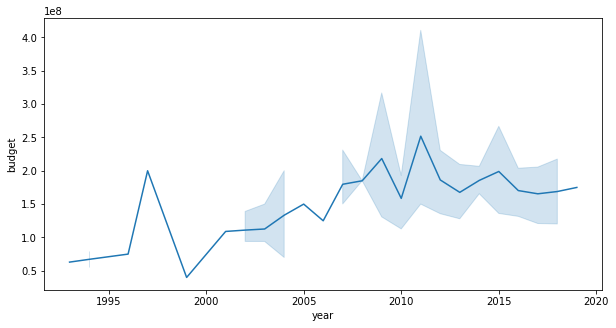

In [173]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = ax = sns.lineplot(x='year', y='budget', data=top100_gross_films)
plt.show()

In [160]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


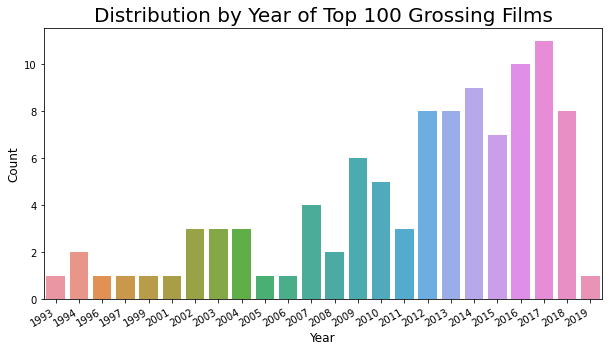

In [218]:
# setting figsize 
fig, ax = plt.subplots(figsize = (10 , 5)) 

# plotting 
ax = sns.barplot(x='year', y= 'count', data=t50_count_by_year)

#adjusting xticks
plt.xticks(rotation=30, ha='right')

#label for x-axis 
ax.set_xlabel( "Year" , size = 12 ) 
  
#label for y-axis 
ax.set_ylabel( "Count" , size = 12 ) 
  
#title for plot 
ax.set_title( "Distribution by Year of Top 100 Grossing Films" , size = 20 ) 
  
# render 
plt.show() 

In [159]:
t100_gross_by_roi = top100_gross_films.sort_values(by='ww_roi', ascending=False)
t100_gross_by_roi.head()

,title,budget,ww_gross,ww_net,ww_roi,date,genres,year
1619,It,35000000.0,6.974580e+08,6.624580e+08,18.927371,2017-09-08,"Classics, Comedy, Drama, Romance",2017
3749,The Sixth Sense,40000000.0,6.728063e+08,6.328063e+08,15.820157,1999-08-06,Mystery & Suspense,1999
1689,Jurassic Park,63000000.0,1.038813e+09,9.758126e+08,15.489089,1993-06-11,"Action & Adventure, Mystery & Suspense, Scienc...",1993
505,Bohemian Rhapsody,55000000.0,8.949853e+08,8.399853e+08,15.272461,2018-11-02,Drama,2018
2040,Minions,74000000.0,1.160336e+09,1.086336e+09,14.680219,2015-07-10,"Animation, Comedy, Kids & Family",2015


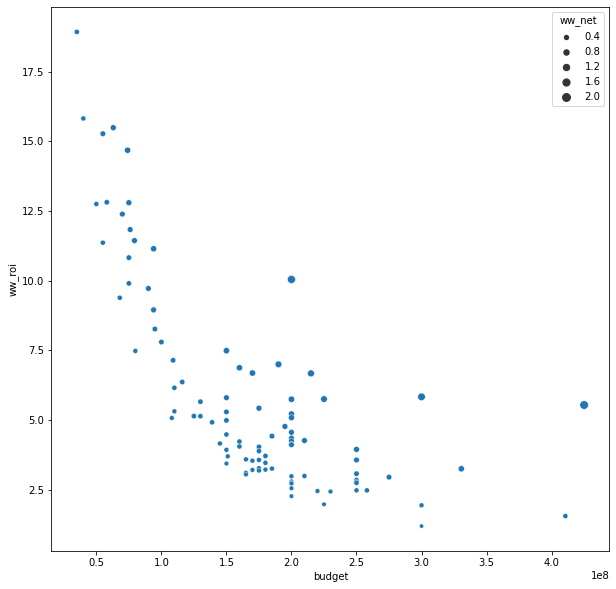

In [213]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.scatterplot(x='budget', y='ww_roi', data=top100_gross_films, size='ww_net')
plt.show()

In [214]:
title_net = df[['title','budget', 'ww_gross', 'ww_net', 'date']]
unique_titles = title_net.groupby('title').first().reset_index()
top100_net_films = unique_titles.sort_values(by='ww_net', ascending=False).head(100)
top100_net_films

,title,budget,ww_gross,ww_net,date
321,Avatar,425000000.0,2.776345e+09,2.351345e+09,2009-12-18
3920,Titanic,200000000.0,2.208208e+09,2.008208e+09,1997-12-19
323,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,2018-04-27
1691,Jurassic World,215000000.0,1.648855e+09,1.433855e+09,2015-06-12
1223,Furious 7,190000000.0,1.518723e+09,1.328723e+09,2015-04-03
...,...,...,...,...,...
3033,The Amazing Spider-Man,220000000.0,7.578903e+08,5.378903e+08,2012-07-03
1108,Fifty Shades of Grey,40000000.0,5.709981e+08,5.309981e+08,2015-02-13
3406,The Incredibles,92000000.0,6.147268e+08,5.227268e+08,2004-11-05
1761,Kung Fu Panda 2,150000000.0,6.648375e+08,5.148375e+08,2011-05-26


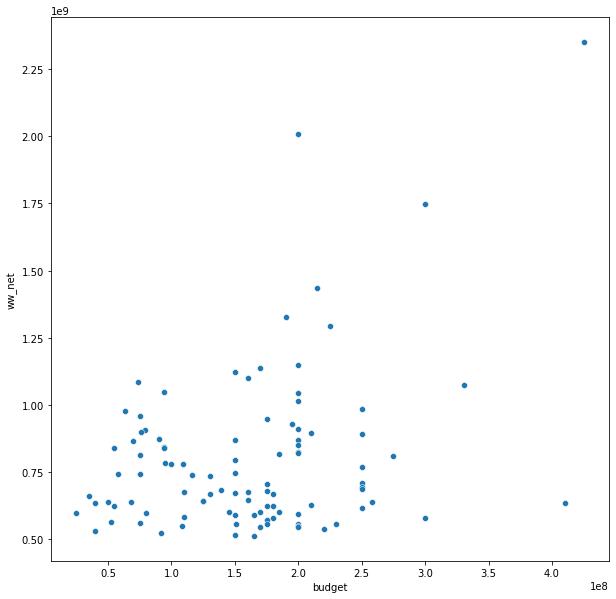

In [216]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="budget", y="ww_net");

In [20]:
title_roi = df[['title','budget', 'ww_gross', 'ww_roi', 'date']]
unique_titles = title_roi.groupby('title').first().reset_index()
top20_roi_films = unique_titles.sort_values(by='ww_roi', ascending=False).head(20)
top20_roi_films

,title,budget,ww_gross,ww_roi,date
1909,Mad Max,200000.0,99750000.0,497.750000,1980-03-21
2303,Paranormal Activity,450000.0,194183034.0,430.517853,2009-09-25
3294,The Gallows,100000.0,41656474.0,415.564740,2015-07-10
3090,The Blair Witch Project,600000.0,248300000.0,412.833333,1999-07-14
2936,Super Size Me,65000.0,22233808.0,341.058585,2004-05-07
352,Bambi,858000.0,268000000.0,311.354312,1942-08-13
996,El Mariachi,7000.0,2041928.0,290.704000,1993-02-26
2557,Rocky,1000000.0,225000000.0,224.000000,1976-11-21
3129,The Brothers McMullen,50000.0,10426506.0,207.530120,1995-08-09
3797,The Texas Chainsaw Massacre,140000.0,26572439.0,188.803136,1974-10-18


In [ ]:
split_list = []
for genre in df.genres:
    split_list += genre.split(',')

raw_genres = list(set(split_list))
raw_genres

In [ ]:
split_list = []
for genre in df.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres

In [ ]:
len(genres)

In [ ]:
df[(df['genres'] == 'Science Fiction & Fantasy') |\
   (df['genres'] == ' Science Fiction & Fantasy')]